# Introdução a séries temporais

### Métodos preditivos

Previsões de séries temporaris é um tópico com muitas aplicações possíveis, tais como previsão de preço de ativos, previsão do tempo, planejamento de negócios, alocação de recursos e muitos outros.

Um séries temporais é usualmente modelada sob um processo estocástico $Y(t)$, i.e., uma sequência de variáveis aleatórias. Em uma previsão, estamos no momento $t$ e temos interesse de estimar $Y(t+1)$, usando somente as informações disponíveis até o momento $t$.

# Modelo Naive 

O modelo Naive é o exemplo mais básico e "inocente" de preditor para uma série temporal. A idéia do modelo é a de que o valor previsto para o período atual $t$ seja igual ao valor do período $t-1$. Para demonstrar a aplicação do modelo _Naive_, utilizaremos os dados contidos no arquivo ```shampo.csv```, representando as vendas mensais de shampoo 

In [80]:
import pandas as pd 
import matplotlib.pyplot as plt

df = pd.read_csv('dados/shampoo.csv')
df.Month = pd.to_datetime(df.Month)
df.set_index('Month', inplace=True)

Para avaliar a qualidade do modelo, faremos a previsão para toda a série temporal utilizando o comando ```Series.shift()```. Criaremos uma nova coluna chamada ```Sales_prediction``` como sendo o deslocamento de um período da coluna ```Sales```. 

In [81]:
df['naive_prediction'] = df.Sales.shift(1)
df.head()

,Sales,naive_prediction
Month,,
2000-01-01,266.0,NaN
2000-02-01,145.9,266.0
2000-03-01,183.1,145.9
2000-04-01,119.3,183.1
2000-05-01,180.3,119.3


Plotando as duas séries, é possível observar o comportamento do modelo.

<AxesSubplot:xlabel='Month'>

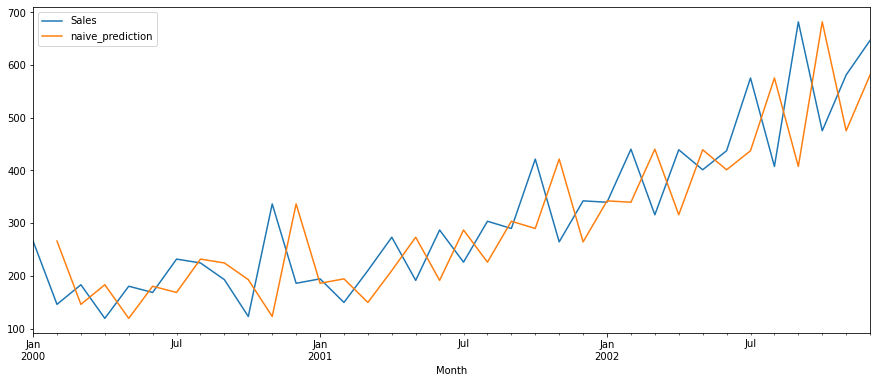

In [82]:
df.plot(figsize=(15,6))

### Validação 

Faremos a validação do modelo _Naive_ calculando o erro médio quadrático entre as previsões e os valores observados. Para tanto, faremos o cálculo da diferença quadrática entre a coluna ```Sales``` e a coluna ```naive_prediction```. Guardaremos a ```Series``` gerada em uma variável chamada ```errors```. Para calcular a média do erro, utilizamos o comando ```Series.mean()```. 

In [83]:
((df.Sales - df.naive_prediction) ** 2).mean()

11715.388285714287

O modelo _Naive_ é utilizaado como referência para modelos mais sofisticados. A idéia é que modelos de previsão possuam erro médio quadrático menor que o mdoelo _Naive_. Caso contrário, temos um modelo extremamente ineficaz. 

# Modelo AutoRegressivo (AR) 

Em modelos de regressão múltipla, fazemos a previsão da variável de interesse utilizando a combinação linear das variáveis preditoras. Em um modelo autoregressivo, fazemos a previsão da variável de interesse utilizando a combinação linear dos valores passados da mesma variável. O termo autoregressivo indica que o processo é definido como um modelo de regressão de uma variável por ela mesma. 

Assim, um modelo autoregressivo de ordem &p& pode ser escrito como 

$$y_t = c + \beta_1y_{t-1} + \beta_2y_{t-2} + \cdots + \beta_p y_{t - p} + \epsilon_t$$

onde $\epsilon_t$ é o ruído branco. Nos referimos a um modelo AR($p$) como um modelo autoregressivo de ordem $p$.

Faremos a implementação de um modelo AR(1) para o exemplo do shampoo. Para tanto, criaremos um novo ```DataFrame``` chamdo ```df1``` que contém a coluna ```Sales``` e a coluna ```x1```. Onde ```x1``` representa o valor da venda com _lag_ de 1 período. 


In [84]:
df1 = df.drop('naive_prediction', axis=1)
df1['x1'] = df1.Sales.shift(1)
df1.dropna(axis=0, inplace=True)
df1.head()

,Sales,x1
Month,,
2000-02-01,145.9,266.0
2000-03-01,183.1,145.9
2000-04-01,119.3,183.1
2000-05-01,180.3,119.3
2000-06-01,168.5,180.3


Trataremos o modelo AR(1) como uma regressão linear simples, onde ```x1``` é a variável independente e ```Sales``` é a variável dependente. Utilizando a classe ```LinearRegression``` do pacote sklearn, podemos criar o modelo de regressão que equivale ao modelo autoregressivo AR(1).

In [85]:
from sklearn.linear_model import LinearRegression

X = df1.x1.values
y = df1.Sales.values

reg = LinearRegression().fit(X.reshape(-1, 1), y)
predictions = reg.predict(X.reshape(-1, 1))
errors = (y - predictions) ** 2
errors.mean()

10668.73613429366

Rodando o modelo de regressão para o AR(1) obtemos $r^2 = 10668.73$, valor inferior ao obtido com o modelo _Naive_. Abaixo, temos a representação visual do modelo de regressão linear.

Text(0, 0.5, 'Sales')

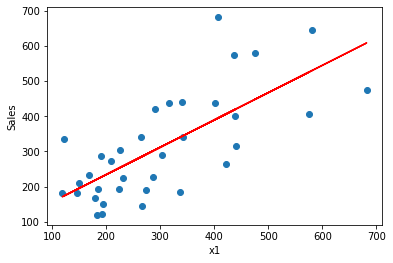

In [86]:
plt.scatter(X, y)
plt.plot(X, reg.predict(X.reshape(-1, 1)), color='red')
plt.xlabel('x1')
plt.ylabel('Sales')

Para visualizar o modelo na forma de uma série temporal criaremos uma nova coluna no DataFrame df1 chamada ar_1.

<AxesSubplot:xlabel='Month'>

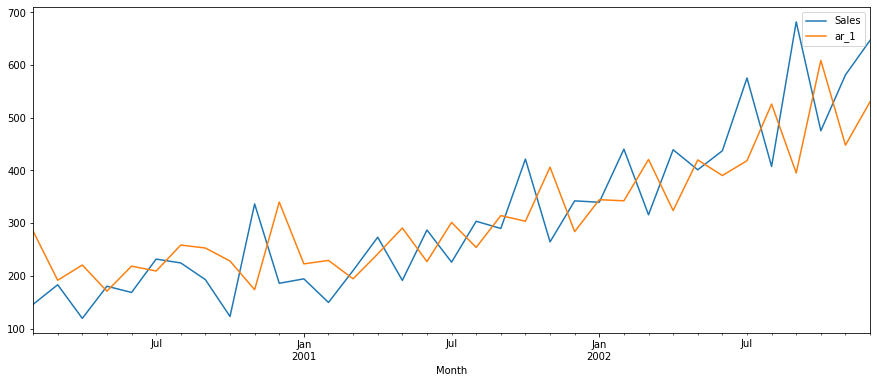

In [87]:
df1['ar_1'] = reg.predict(X.reshape(-1, 1))
df1[['Sales', 'ar_1']].plot(figsize=(15, 6))

Faremos, agora, a aplicação do modelo de regressão para AR(2). Para tanto, acrescentaremos a coluna denominada ```x2```, representando o _lag_ de 2 períodos. Nesse caso, temos um modelo de regressão linear múltipla com ```x1``` e ```x2``` como variáveis independentes e ```Sales``` como variável dependente.

In [88]:
df1['x2'] = df.Sales.shift(2)
df1.dropna(axis=0, inplace=True)
df1.head()

,Sales,x1,ar_1,x2
Month,,,,
2000-03-01,183.1,145.9,191.610723,266.0
2000-04-01,119.3,183.1,220.566317,145.9
2000-05-01,180.3,119.3,170.905917,183.1
2000-06-01,168.5,180.3,218.386864,119.3
2000-07-01,231.8,168.5,209.202025,180.3


In [89]:
X = df1[['x1', 'x2']]
y = df1.Sales.values

reg2 = LinearRegression().fit(X, y)
predictions = reg2.predict(X)
errors = (y - predictions) ** 2
errors.mean()

5154.048667052167

O novo modelo possui $r^2=5154.04$

<AxesSubplot:xlabel='Month'>

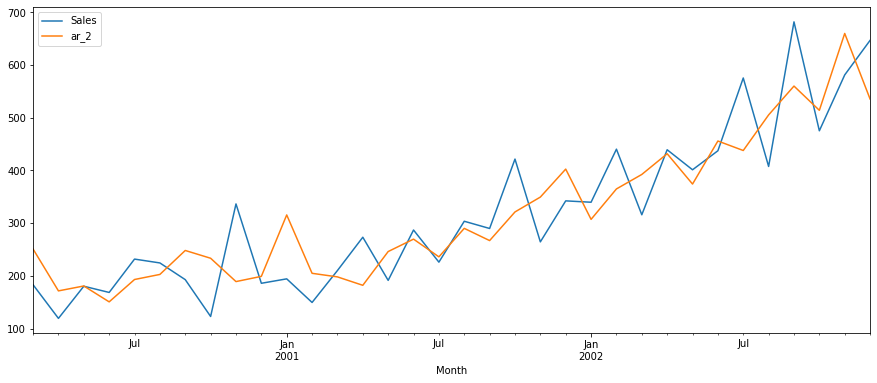

In [90]:
df1['ar_2'] = reg2.predict(X)
df1[['Sales', 'ar_2']].plot(figsize=(15, 6))

# Utilizando o pacote statsmodels

Para facilitar o uso de modelos autoregressivos, utilizaremos o pacote ```statsmodels```. O modelo autoregressivo encontra-se no subpacote ```tsa.ar_model```. Para importar utilizamos o comando ```from statsmodels.tsa.ar_model import AR```. Para criar o modelo, utilzamos o comando ```AR(Series).fit(p)```, onde $p$ é o número de períodos passados (_lag_) considerados no modelo.

Faremos a criação de modelo AR(2) para compara com o resultado gerado anteriormente. Chamaremos o modelo criado de ```ar_2```.

In [91]:
from statsmodels.tsa.ar_model import AR

ar_2 = AR(df.Sales, freq='MS').fit(2)

NotImplementedError: AR has been removed from statsmodels and replaced with statsmodels.tsa.ar_model.AutoReg.

Utilizando o atributo ```resid```, obtemos os erros residuais das previsões de cada período da série na forma de um objeto do tipo ```Series``` do pandas. Podemos utilizar essa informação para calcular o erro quadrático do modelo elevando a ```Series``` contendo os erros residuais por 2 e calculando a média do resultado.

In [ ]:
(ar_2.resid ** 2).mean()

O resultado obtido é o mesmo do modelo criado a partir do modelo de regressão linear. 

Para analisar de forma descritiva os erros do modelo, temos a possibilidade de utilizar o comando ```Series.describe()```. 

In [ ]:
ar_2.resid.describe()

A média dos erros está muito próxima de zero, indicando que não existe uma proporção maior de erros pra cima ou pra baixo. O desvio padrão nos dá uma de variabilidade do erro e os quartis mostram a distribuição do mesmo.

Pra facilitar a análise da distribuição dos erros, podemos utilizar gráficos do tipo histograma e boxplot. Geramos o boxplot dos erros utilizando o comando ```Series.plot(kind='box')```.

In [ ]:
ar_2.resid.plot(kind='box')

Analisando o gráfico percebemos que a mediana (representada pela linha verde) está próxima do valor zero(com valor igual a 3.53).A posição da mediana na "caixa" do boxplot que os erros estão mais dispersos abaixo da mediana. 

A análise pode ser finalizada com o uso do histograma dos erros. Para criar o histograma, utilizamos o comando ```Series.hist()```.

In [ ]:
ar_2.resid.hist()